In [ ]:
'''
### Important before running this notebook!

- This notebook must be placed inside the Lag-liama repository. 
- Do not copy or run it outside of the repo — it depends on the repository structure (notebooks/, external/, utils/, etc.).
To run: 
1. Clone the repository: git clone https://github.com/time-series-foundation-models/lag-llama.git
                         cd timesfm
2. Put this notebook inside of the origin folder of repository
3. Make sure you have internet access (needed to install dependencies and download pretrained checkpoints)
'''

In [7]:
import os, sys, pathlib
import matplotlib.pyplot as plt
import pandas as pd  # requires: pip install pandas
import numpy as np
import torch
from tqdm import tqdm

In [2]:
import importlib, numpy as np
from gluonts.time_feature import lag as _lag
importlib.reload(_lag)

_orig = _lag.get_lags_for_frequency

def _patched_get_lags(freq_str, lag_ub=None, num_lags=None, num_default_lags=1):
    if isinstance(freq_str, (int, np.integer)):
        return [int(freq_str)]
    if isinstance(freq_str, str) and freq_str.startswith("Q"):
        freq_str = "Q-DEC"
    return _orig(freq_str, lag_ub=lag_ub, num_lags=num_lags, num_default_lags=num_default_lags)

_lag.get_lags_for_frequency = _patched_get_lags

import lag_llama.gluon.estimator as _est_mod
importlib.reload(_est_mod)

<module 'lag_llama.gluon.estimator' from '/Users/dmitry/lag-llama/lag_llama/gluon/estimator.py'>

In [15]:
from huggingface_hub import hf_hub_download

ckpt_path = hf_hub_download(
    "time-series-foundation-models/lag-llama",
    filename="lag-llama.ckpt"
)
safetensors_path = hf_hub_download(
    "time-series-foundation-models/lag-llama",
    filename="model.safetensors"
)
print(ckpt_path, safetensors_path)

/Users/dmitry/.cache/huggingface/hub/models--time-series-foundation-models--lag-llama/snapshots/72dcfc29da106acfe38250a60f4ae29d1e56a3d9/lag-llama.ckpt /Users/dmitry/.cache/huggingface/hub/models--time-series-foundation-models--lag-llama/snapshots/72dcfc29da106acfe38250a60f4ae29d1e56a3d9/model.safetensors


In [4]:
#Берем синтетические данные, анлогичные, как они были созданы для chronos
def generate_univariate_data(n=1000, T=12, n_anomalies=0, max_anomaly_size=5, n_normal_start=100):
    t = np.arange(n)
    t0 = np.random.randint(0, T)
    x = np.sin(2 * np.pi / T * (t + t0))
    y = np.zeros(n)

    for k in range(n_anomalies):
        i_start = np.random.randint(n_normal_start, n)
        i_end = i_start + np.random.randint(1, max_anomaly_size + 1)
        level = np.random.rand()
        x[i_start:i_end] = level
        y[i_start:i_end] = 1

    return x.reshape(-1, 1), y

In [5]:
X_normal, y_normal = generate_univariate_data(n=500, n_anomalies=0)
X_attack, y_attack = generate_univariate_data(n=500, n_anomalies=10)

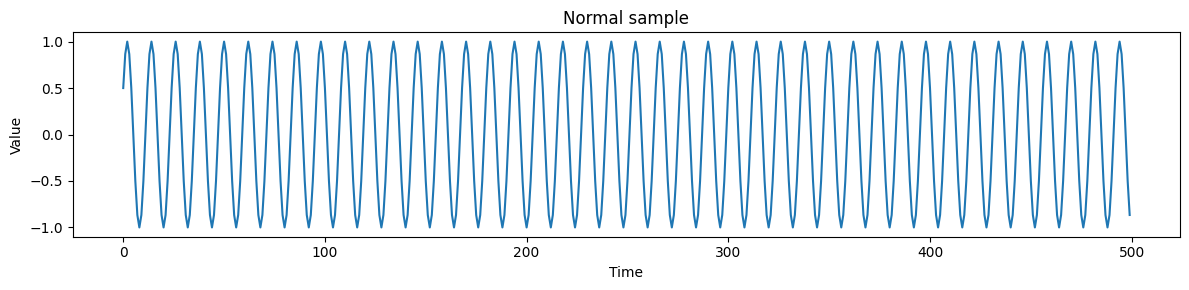

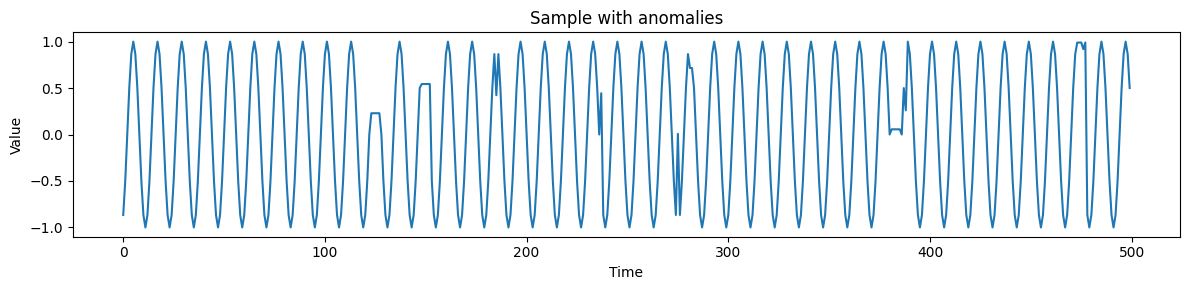

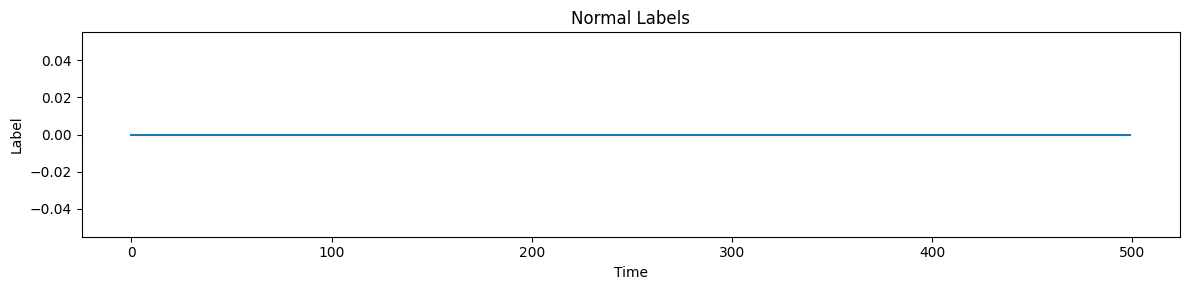

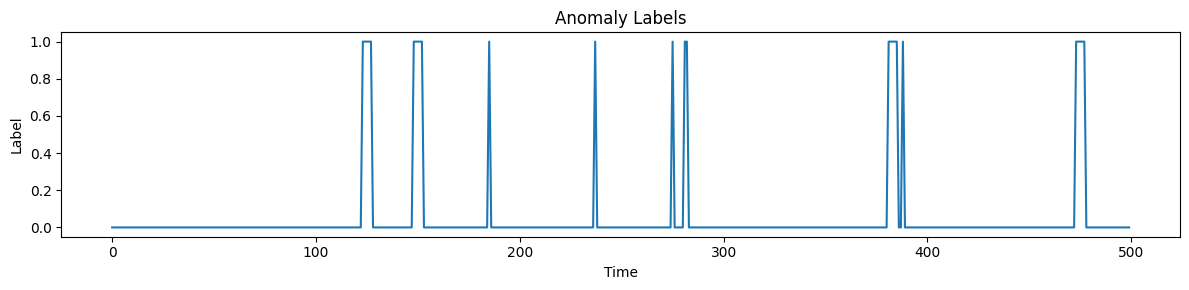

In [8]:
# Визуализация нормального ряда
plt.figure(figsize=(12, 3))
plt.plot(X_normal)
plt.title("Normal sample")
plt.xlabel("Time")
plt.ylabel("Value")
plt.tight_layout()
plt.show()

# Визуализация ряда с аномалиями
plt.figure(figsize=(12, 3))
plt.plot(X_attack)
plt.title("Sample with anomalies")
plt.xlabel("Time")
plt.ylabel("Value")
plt.tight_layout()
plt.show()

# Метки без аномалий
plt.figure(figsize=(12, 3))
plt.plot(y_normal)
plt.title("Normal Labels")
plt.xlabel("Time")
plt.ylabel("Label")
plt.tight_layout()
plt.show()

# Метки аномалий
plt.figure(figsize=(12, 3))
plt.plot(y_attack)
plt.title("Anomaly Labels")
plt.xlabel("Time")
plt.ylabel("Label")
plt.tight_layout()
plt.show()

In [12]:
import numpy as np

def estimate_period_fft(x, min_T=4, max_T=512):
    x = np.asarray(x, dtype=float)
    x = x - np.nanmedian(x)
    n = len(x)

    spec = np.abs(np.fft.rfft(x))
    freqs = np.fft.rfftfreq(n, d=1.0)

    with np.errstate(divide="ignore", invalid="ignore"):
        periods = np.where(freqs > 0, 1.0 / freqs, np.inf)

    mask = (freqs > 0) & (periods >= min_T) & (periods <= max_T)

    if not np.any(mask):
        k = 1 + np.argmax(spec[1:])
        T = int(max(2, round(1.0 / freqs[k])))
        return T

    idx_in_mask = np.argmax(spec[mask])
    k = np.nonzero(mask)[0][idx_in_mask]

    T = int(max(2, round(1.0 / freqs[k])))
    return T

In [20]:
x_norm = X_normal.squeeze(-1).astype(np.float32)
T = estimate_period_fft(x_norm, min_T=4, max_T=min(512, len(x_norm)//2))

context_len = 2 * T
pred_len = max(1, int(0.25 * T))
step = max(1, pred_len // 2)
print(f"T={T}, context_len={context_len}, pred_len={pred_len}, step={step}")

Estimated T=12, context_len=24, pred_len=3, step=1


In [16]:
import torch

sd = torch.load(ckpt_path, map_location="cpu", weights_only=False)["state_dict"]
vocab_size = int(sd["model.transformer.wte.weight"].shape[1])
d_model = int(sd["model.transformer.wte.weight"].shape[0])

print("vocab_size:", vocab_size)  # ожидалось ~92
print("d_model :", d_model)     # ожидалось 144

vocab_size: 92
d_model   : 144


In [26]:
extra_tokens = 2         
vocab_ckpt = 92              
lags_ints = list(range(1, vocab_ckpt - extra_tokens + 1))
T = estimate_period_fft(X_normal.squeeze(-1))
#lags_seq = list(range(1, T*4, 1))

# выберем разбиение d_model = n_head * n_embd_per_head
n_head = 3
n_embd_per_head = d_model // n_head

from lag_llama.gluon.estimator import LagLlamaEstimator

estimator = LagLlamaEstimator(
    prediction_length = pred_len,
    context_length = context_len,
    input_size = 1,
    batch_size = 1,
    n_layer = 4,
    n_embd_per_head = n_embd_per_head,
    n_head = n_head,
    max_context_length = 2048,
    scaling = "robust",
    num_parallel_samples = 100,
    dropout=0.0,
    lags_seq = lags_ints,                 
    ckpt_path = ckpt_path,
    trainer_kwargs = dict(accelerator="cpu", devices=[0]),
)

tr = estimator.create_transformation()
lm = estimator.create_lightning_module()
predictor = estimator.create_predictor(tr, lm)

In [18]:
import numpy as np
import pandas as pd
from gluonts.dataset.common import ListDataset

def ll_forecast_mean(predictor, series_window: np.ndarray, pred_len: int, freq="D"):
    start = pd.Timestamp("2000-01-01")  # любая валидная дата
    ds = ListDataset([{"start": start, "target": series_window.astype(np.float32)}], freq=freq)
    fcst = next(iter(predictor.predict(ds)))
    return np.asarray(fcst.mean, dtype=np.float32)

In [23]:
from tqdm.auto import tqdm
import time
import numpy as np

x = X_attack.squeeze(-1).astype(np.float32)

freq = "D"

max_lag = max(estimator.lags_seq) if getattr(estimator, "lags_seq", None) else 0
history_len = int(context_len + max_lag)

x_pred = np.zeros_like(x, dtype=np.float32)
anomaly_scores = np.zeros_like(x, dtype=np.float32)  # аккумулируем по времени
counts = np.zeros_like(x, dtype=np.int32)

t0 = time.time()

for start in tqdm(range(0, len(x) - context_len - pred_len + 1, step), desc="Sliding windows"):
    end_ctx = start + context_len
    end_all = end_ctx + pred_len

    start_hist    = max(0, end_ctx - history_len)
    series_window = x[start_hist:end_ctx]

    yhat  = ll_forecast_mean(predictor, series_window, pred_len, freq=freq).astype(np.float32)
    ytrue = x[end_ctx:end_all].astype(np.float32)

    bias  = float(np.mean(ytrue - yhat))
    yhat_deb = yhat + bias

    #mae вместо mse
    err_vec = np.abs(ytrue - yhat_deb)

    sl = slice(end_ctx, end_all)
    x_pred[sl] += yhat_deb
    anomaly_scores[sl] += err_vec
    counts[sl] += 1

mask = counts > 0
eps = 1e-8
x_pred[mask] = x_pred[mask] / (counts[mask] + eps)
anomaly_scores[mask] = anomaly_scores[mask] / (counts[mask] + eps)

sc = anomaly_scores.copy()
valid = np.isfinite(sc) & mask
if valid.any():
    med = float(np.median(sc[valid]))
    mad = float(np.median(np.abs(sc[valid] - med))) + eps
    sc[valid] = (sc[valid] - med) / mad

    alpha = 0.2
    for i in range(1, len(sc)):
        if valid[i-1] and valid[i]:
            sc[i] = alpha * sc[i] + (1 - alpha) * sc[i-1]

q = 0.99
thr = float(np.quantile(sc[valid], q)) if valid.any() else np.inf
anomaly_flags = sc > thr

Sliding windows:   0%|          | 0/474 [00:00<?, ?it/s]

done in 28.3s | thr(q=0.99)=2.628


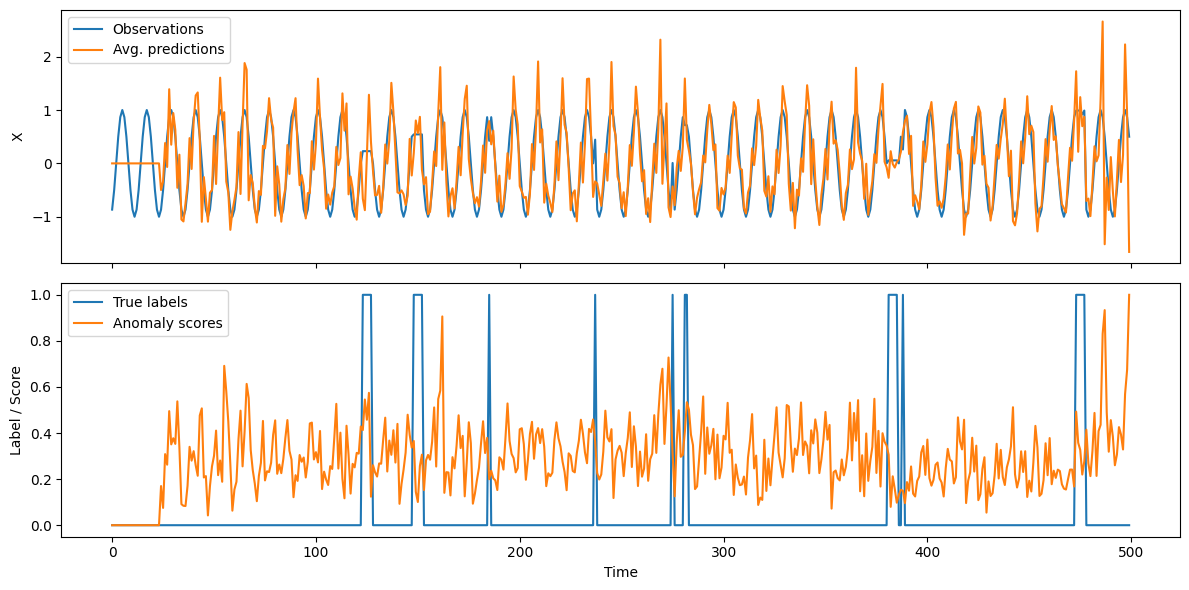

In [24]:
import numpy as np
import matplotlib.pyplot as plt

t = np.arange(len(x))
x_plot = np.asarray(x, dtype=np.float32).ravel()
x_pred_plot = np.asarray(x_pred, dtype=np.float32).ravel()
y_true = np.asarray(y_attack, dtype=np.float32).ravel()[:len(x)]
scores = np.asarray(anomaly_scores, dtype=np.float32).ravel()
scores_norm = scores / (scores.max() + 1e-8)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

ax1.plot(t, x_plot, label='Observations')
ax1.plot(t, x_pred_plot, label='Avg. predictions')
ax1.set_ylabel('X')
ax1.legend()

ax2.plot(t, y_true, label='True labels')
ax2.plot(t, scores_norm, label='Anomaly scores')
ax2.set_xlabel('Time')
ax2.set_ylabel('Label / Score')
ax2.legend()

fig.tight_layout()
plt.show()

In [34]:
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
import numpy as np

y_true = np.asarray(y_attack, dtype=np.float32).ravel()
scores = np.asarray(anomaly_scores, dtype=np.float32).ravel()

n = min(len(y_true), len(scores))
y_true = y_true[:n]
scores = scores[:n]

y_true_eval = y_true[context_len:]
scores_eval = scores[context_len:]

scores_norm = (scores_eval - scores_eval.min()) / (scores_eval.max() - scores_eval.min() + 1e-8)

best_f1, best_p, best_r, best_thr = 0, 0, 0, None
for thr in np.linspace(0, 1, 200):
    y_pred = (scores_norm >= thr).astype(int)
    p, r, f1, _ = precision_recall_fscore_support(y_true_eval, y_pred, average="binary", zero_division=0)
    if f1 > best_f1:
        best_f1, best_p, best_r, best_thr = f1, p, r, thr

roc_auc = roc_auc_score(y_true_eval, scores_norm)

print("Best threshold search:")
print(f"threshold={best_thr:.3f} | precision={best_p:.5f} | recall={best_r:.5f} | f1={best_f1:.5f} | roc_auc={roc_auc:.5f}")

Best threshold search:
threshold=0.513 | precision=0.13636 | recall=0.11538 | f1=0.12500 | roc_auc=0.48821
